In [ ]:
!pip install SoccerNet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd drive/MyDrive/Action\ Spotting\ CSE\ 610/

/content/drive/MyDrive/Action Spotting CSE 610


In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import tensorflow
import keras

from util.dataset_generator import *
from util.metrics import *
import src.global_variables as GV

In [3]:
# GPU optimization
tensorflow.config.run_functions_eagerly(True)
tensorflow.data.experimental.enable_debug_mode()

## Util Functions
---

In [4]:
timestep = 1

In [5]:
from SoccerNet.Downloader import getListGames

trainList = []
trainList.extend(getListGames(['train']))
trainList.extend(getListGames(['valid']))
testList = getListGames(['test'])
challengeList = getListGames(['challenge'])

print(f"Games in trainList: {len(trainList)}")
print(f"Games in testList: {len(testList)}")
print(f"Games in challengeList: {len(challengeList)}")

Games in trainList: 400
Games in testList: 100
Games in challengeList: 50


In [6]:
context = np.array([0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1., 
                    0.95, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5], dtype="float")
context = np.expand_dims(context, axis=1)

map = {
    0: [1, 0, 0],
    -1: [0, 1, 0],
    1: [0, 0, 1],
}

def contextLabel(labels):
    # labels = labels * context
    label = np.sum(labels, axis=0)
    return label

def binaryLabel(labels):
    # label = np.sum(labels, axis=0)
    # val = np.sum(labels)
    # return map[np.sum(labels)]
    if np.sum(labels) == 0:
        return 0
    else:
        return 1

def divideGame(features, labels, binary=True, stride=1):
    feat_ = []
    lab_ = []

    for i in range(0, len(features), stride):
        if i+timestep > len(features):
            break
        feat_.append(features[i : i+timestep])
        if binary:
            lab_.append(binaryLabel(labels[i : i+timestep]))
        else:
            lab_.append(contextLabel(labels[i : i+timestep]))

    feat_ = np.asanyarray(feat_)
    lab_ = np.asanyarray(lab_)
    feat_ = np.reshape(feat_, (feat_.shape[0], feat_.shape[-1]))
    return (feat_, lab_)


##Train Naive Classifier
---

In [43]:
# import
from tensorflow.keras.layers import (
	Dense,
    Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras import Input

class NaiveClassifier:

    @staticmethod
    def build(dim=8576):
        inputShape = (dim)

        inputs = Input(inputShape)
        x = Dense(64, activation="relu")(inputs)
        x = Dropout(0.2)(x)
        x = Dense(64, activation="relu")(x)
        x = Dropout(0.2)(x)
        x = Dense(3, activation="softmax")(x)

        # create the model
        model = Model(inputs, x, name="naive_classifier")

        return model

In [44]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy

opt = Adam(learning_rate=1e-3)
loss = CategoricalCrossentropy()
# loss = BinaryCrossentropy()
model = NaiveClassifier.build()
model.compile(loss=loss, optimizer=opt,
    metrics=["accuracy"])

In [45]:
model.summary()

Model: "naive_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8576)]            0         
                                                                 
 dense_3 (Dense)             (None, 64)                548928    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 553,283
Trainable params: 553,283
No

In [47]:
def getBinaryClassWeights(labels):
    n_samples = len(labels)
    n_classes = 3

    class_count = []
    class_count.append(len(np.where(labels == 0)[0]))
    class_count.append(len(np.where(labels < 0)[0]))
    class_count.append(len(np.where(labels > 0)[0]))

    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights))
    return dict(zip(class_labels, class_weights))
    # return {0: class_weights[0], -1: class_weights[1], 1: class_weights[2]}

In [48]:
getBinaryClassWeights(labels)

{0: 0.3464918814241025, 1: 58.88607594936709, 2: 10.314855875831485}

In [52]:
from numpy.core.fromnumeric import shape
acc, loss = [], []

batch = 10

for idx in range(0, len(trainList), batch):
    print(f"[INFO] training on game: {idx+1}-{idx+batch}/400")
    features, labels = [], []

    for fp in range(idx, idx+batch):
        filepath = "labels/" + trainList[fp] + "/" 
        # print(filepath)   
        [features_1, features_2, labels_1, labels_2] = getGameData(filepath, 
                                        num_classes=17, 
                                        event_mapping=GV.EVENT_DICTIONARY_V2)
        if features_1 is None:
            continue

        features_1, labels_1 = divideGame(features_1, labels_1)
        features_2, labels_2 = divideGame(features_2, labels_2)

        if len(features) != 0:
            features = np.concatenate((features, features_1, features_2), axis=0)
            labels = np.concatenate((labels, labels_1, labels_2), axis=0)
        else:
            features = np.concatenate((features_1, features_2), axis=0)
            labels = np.concatenate((labels_1, labels_2), axis=0)
    
    train_df = tensorflow.data.Dataset.from_tensor_slices((features, labels))
    train_df = train_df.cache().shuffle(200).batch(32).prefetch(tensorflow.data.experimental.AUTOTUNE)

    H = model.fit(train_df,
                  epochs=2,
                  class_weight=getBinaryClassWeights(labels))
    acc.extend(H.history["accuracy"])
    loss.extend(H.history["loss"])

[INFO] training on game: 1-10/400


KeyError: ignored

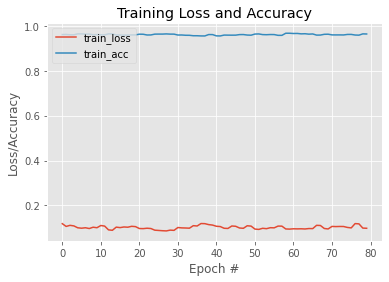

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(loss, label="train_loss")
plt.plot(acc, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [ ]:
model.save("models/naive_classifier")

INFO:tensorflow:Assets written to: models/naive_classifier/assets


##Test Naive Classifier and Generate Windows
---

In [6]:
# load naive classifier
model = tensorflow.keras.models.load_model("models/naive_classifier")

In [ ]:
# testing
print(filepaths[45])
[features, labels] = getGameData(filepaths[45][38:], 
                                num_classes=9, 
                                event_mapping=GV.MOD_EVENT_DICTIONARY_V2)
features, labels = divideGame(features, labels)
pred = model.predict_on_batch(features)

In [ ]:
# plot probability predictions for first 3 mins of game
plt.style.use("ggplot")
plt.figure()
plt.plot(pred[200:300], label="pred")
plt.title("Event Prediction")
plt.xlabel("Time (seconds)")
plt.ylabel("Predictions")
plt.legend(loc="upper left")

In [10]:
# get windows from predictions
def getWindows(pred, threshold=0.2):
    windows = []
    pred = pred > threshold
    idx = 0

    while idx < len(pred):
        if pred[idx]:
            start = idx
            while idx < len(pred) and pred[idx]:
                idx += 1
            windows.append([start, idx-1])
        idx += 1
    
    return np.asarray(windows)

In [11]:
# segment actions from game for event classification
def segmentActions(windows, features, labels, max_window=15):
    feat_ = []
    lab_ = []

    for (start, end) in windows:
        temp_feat = []
        temp_feat.extend([np.array(features[f]) for f in range(start, end+1)])
        if end+1 - start < max_window: 
            temp_feat.extend(np.array([0] * features.shape[-1]) for _ in range(max_window - (end+1 - start)))

        temp_feat = np.asarray(temp_feat)
        feat_.append(np.array(temp_feat))

        temp_lab = contextLabel(labels[start : end+1])
        if np.sum(temp_lab) > 1:
            temp_lab = temp_lab / np.sum(temp_lab)
        lab_.append(temp_lab)

    feat_ = np.array(feat_)
    lab_ = np.array(lab_)
    return (feat_, lab_)

In [4]:
def getEventWindows(features, labels):
    feat_ = []
    lab_ = []

    for (idx, label) in enumerate(labels):
        if np.sum(label) > 0:
            start = idx - 5
            end = idx + 5
            temp_feat = []
            if start < 0:
                arr = [np.array(features[f]) for f in range(0, 11)]
                assert(len(arr) == 11)
            elif end > len(labels)-1:
                arr = [np.array(features[f]) for f in range(len(labels)-11, len(labels))]
                assert(len(arr) == 11)
            else:
                arr = [np.array(features[f]) for f in range(start, end+1)]
                assert(len(arr) == 11)
            temp_feat.extend(arr)
            # if end+1 - start < max_window: 
            #     temp_feat.extend(np.array([0] * features.shape[-1]) for _ in range(max_window - (end+1 - start)))
            temp_feat = np.asarray(temp_feat)
            feat_.append(np.array(temp_feat))

            # temp_lab = contextLabel(labels[start : end+1])
            # if np.sum(temp_lab) > 1:
            #     temp_lab = temp_lab / np.sum(temp_lab)
            lab_.append(label)

    feat_ = np.array(feat_)
    lab_ = np.array(lab_)
    return (feat_, lab_)

In [8]:
from pyparsing import actions
# import
from tensorflow.keras.layers import (
	Dense,
    Flatten,
    Dropout,
    LSTM,
    GRU,
    Bidirectional
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input

class ActionClassifier:

    @staticmethod
    def build(timesteps=15, dim=8576, classes=17):
        model = Sequential()
        model.add(Bidirectional(GRU(128, return_sequences=True),
                                input_shape=(timesteps, dim),
                                merge_mode='sum'))
        model.add(Dropout(0.3))
        model.add(Bidirectional(GRU(128), merge_mode='sum'))
        model.add(Dropout(0.2))
        model.add(Flatten())

        # model.add(Dense(64, activation="relu"))
        # model.add(Dense(64, activation="relu"))
        # model.add(Dropout(0.3))

        # Add a Dense layer.
        model.add(Dense(classes, activation="softmax"))

        return model

In [16]:
METRICS = [
            keras.metrics.CategoricalAccuracy(),
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'), 
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy

opt = Adam(learning_rate=1e-4)
loss = CategoricalCrossentropy()
rnn_model = ActionClassifier.build(timesteps=11, classes=8)
rnn_model.compile(loss=loss, optimizer=opt,
    metrics=METRICS, run_eagerly=True)

In [18]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 11, 128)          6686208   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 11, 128)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              198144    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                

In [7]:
def getClassWeights(labels):
    n_samples = len(labels)
    n_classes = len(labels[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in labels:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights))
    return dict(zip(class_labels, class_weights))

In [19]:
# acc, loss = [], []

batch = 25

for j in range(5):

    for idx in range(0, len(trainList), batch):
        print(f"[INFO] training on game: {idx+1}-{idx+batch}/400")

        features, labels = [], []

        for fp in range(idx, idx+batch):
            
            filepath = "labels/" + trainList[fp] + "/"
            # print(filepath)

            [features_1, features_2, labels_1, labels_2] = getGameData(filepath, 
                                                            num_classes=8, 
                                                            event_mapping=GV.MOD_EVENT_DICTIONARY_V2)
            if features_1 is None or features_2 is None:
                continue
        
            # # features_1, _ = divideGame(features_1, labels_1)
            # # features_2, _ = divideGame(features_2, labels_2)

            # pred_1 = model.predict_on_batch(features_1)
            # pred_2 = model.predict_on_batch(features_2)

            # windows_1 = getWindows(pred_1)
            # windows_2 = getWindows(pred_2)

            # # features_1, labels_1 = divideGame(features_1, labels_1, binary=False)
            # # features_2, labels_2 = divideGame(features_2, labels_2, binary=False)

            # [features_1, labels_1] = segmentActions(windows_1, features_1, labels_1)
            # [features_2, labels_2] = segmentActions(windows_2, features_2, labels_2)

            # if features_1 is None or len(features_1.shape) != 3 or \
            #     features_2 is None or len(features_2.shape) != 3:
            #     continue
            
            features_1, labels_1 = getEventWindows(features_1, labels_1)
            features_2, labels_2 = getEventWindows(features_2, labels_2)

            # print(features_1.shape, labels_1.shape)
            # print(features_2.shape, labels_2.shape)

            if len(features) != 0:
                features = np.concatenate((features, features_1, features_2), axis=0)
                labels = np.concatenate((labels, labels_1, labels_2), axis=0)
            else:
                features = np.concatenate((features_1, features_2), axis=0)
                labels = np.concatenate((labels_1, labels_2), axis=0)

        partition = int(len(features) * 0.8)

        train_df = tensorflow.data.Dataset.from_tensor_slices((features[:partition], labels[:partition]))
        train_df = train_df.cache().shuffle(200).batch(32).prefetch(tensorflow.data.experimental.AUTOTUNE)
        val_df = tensorflow.data.Dataset.from_tensor_slices((features[partition:], labels[partition:]))
        val_df = val_df.cache().shuffle(200).batch(32).prefetch(tensorflow.data.experimental.AUTOTUNE)

        H = rnn_model.fit(train_df, 
                        epochs=5,
                        validation_data=val_df,
                        class_weight = getClassWeights(labels))
        # acc.extend(H.history["accuracy"])
        # loss.extend(H.history["loss"])


[INFO] training on game: 1-25/400
Epoch 1/5
133/133 [==============================] - 14s 102ms/step - loss: 1.3472 - categorical_accuracy: 0.5666 - tp: 737.0000 - fp: 72.0000 - tn: 29597.0000 - fn: 3578.0000 - accuracy: 0.8926 - precision: 0.9110 - recall: 0.1708 - auc: 0.9064 - prc: 0.6437 - val_loss: 0.6604 - val_categorical_accuracy: 0.8183 - val_tp: 718.0000 - val_fp: 75.0000 - val_tn: 7343.0000 - val_fn: 360.0000 - val_accuracy: 0.9488 - val_precision: 0.9054 - val_recall: 0.6660 - val_auc: 0.9781 - val_prc: 0.8916
Epoch 2/5
133/133 [==============================] - 14s 102ms/step - loss: 0.9048 - categorical_accuracy: 0.7479 - tp: 2445.0000 - fp: 458.0000 - tn: 29211.0000 - fn: 1870.0000 - accuracy: 0.9315 - precision: 0.8422 - recall: 0.5666 - auc: 0.9624 - prc: 0.8054 - val_loss: 0.4784 - val_categorical_accuracy: 0.8625 - val_tp: 853.0000 - val_fp: 92.0000 - val_tn: 7326.0000 - val_fn: 225.0000 - val_accuracy: 0.9627 - val_precision: 0.9026 - val_recall: 0.7913 - val_auc: 0

In [20]:
# save rnn_model
rnn_model.save("models/action_classifier_7_11window")

INFO:tensorflow:Assets written to: models/action_classifier_7_11window/assets


INFO:tensorflow:Assets written to: models/action_classifier_7_11window/assets


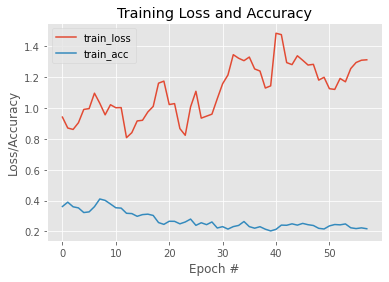

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(loss, label="train_loss")
plt.plot(acc, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [ ]:
rnn_model = tensorflow.keras.models.load_model("models/action_classifier")

In [ ]:
def extendPred(pred, windows, num_frames, classes=17):
    final_pred = np.zeros((num_frames, classes), dtype=int)

    for (p, w) in zip(pred, windows):
        ts = w[0] + ((w[1] - w[0]) // 2)
        idx = np.argmax(p)
        final_pred[ts][idx] = 1
    
    return final_pred

In [ ]:
from sklearn.metrics import precision_score

def accuracy_(pred, labels):
    total, acc = 0, 0
    for p, l in zip(pred, labels):
        if np.sum(p) == np.sum(l) and np.argmax(p) == np.argmax(l):
            acc += 1
        total += 1
    precisions = precision_score(labels, pred, average=None)
    print(f"mAP = {np.sum(precisions) / 7}")
    
    return (acc / total)

In [ ]:
# test action classifier
# game = 1

for game in tl:

    # print(f"[INFO] testing on game: {game}/100")

    filepath = "labels/" + game + "/"
    filepath = game + "/"
    print(filepath)

    [features_1, features_2, labels_1, labels_2] = getGameData(filepath, 
                                                        num_classes=17, 
                                                        event_mapping=GV.EVENT_DICTIONARY_V2)
    if features_1 is None or features_2 is None:
        continue

    features_1, _ = divideGame(features_1, labels_1)
    features_2, _ = divideGame(features_2, labels_2)

    pred_1 = model.predict_on_batch(features_1)
    pred_2 = model.predict_on_batch(features_2)

    windows_1 = getWindows(pred_1)
    windows_2 = getWindows(pred_2)

    features_1, labels_1 = divideGame(features_1, labels_1, binary=False)
    features_2, labels_2 = divideGame(features_2, labels_2, binary=False)

    [features_1, labels_1] = segmentActions(windows_1, features_1, labels_1)
    [features_2, labels_2] = segmentActions(windows_2, features_2, labels_2)

    if features_1 is None or len(features_1.shape) != 3 or \
        features_2 is None or len(features_2.shape) != 3:
        continue

    pred_1 = rnn_model.predict_on_batch(features_1)
    pred_1 = np.asarray(pred_1)
    pred_2 = rnn_model.predict_on_batch(features_2)
    pred_2 = np.asarray(pred_2)

    # pred_1 = extendPred(pred_1, windows_1, len(features_1), 7)
    # pred_2 = extendPred(pred_2, windows_2, len(features_2), 7)

    savePreds((pred_1, pred_2), (windows_1, windows_2), filepath)
    
    # print(f"[INFO] Accuracy on 1st half: {accuracy(pred_1, labels_1) * 100}%")
    # print(f"[INFO] Accuracy on 2nd half: {accuracy(pred_2, labels_2) * 100}%")

    # game += 1

labels/england_epl/2016-2017/2016-08-27 - 14-30 Tottenham 1 - 1 Liverpool/
[INFO] Accuracy on 1st half: 61.111111111111114%
[INFO] Accuracy on 2nd half: 46.464646464646464%
labels/england_epl/2016-2017/2016-09-24 - 14-30 Manchester United 4 - 1 Leicester//
[INFO] Accuracy on 1st half: 56.16438356164384%
[INFO] Accuracy on 2nd half: 63.1578947368421%
labels/europe_uefa-champions-league/2016-2017/2016-11-01 - 22-45 Manchester City 3 - 1 Barcelona//
[INFO] Accuracy on 1st half: 68.67469879518072%
[INFO] Accuracy on 2nd half: 63.23529411764706%
labels/germany_bundesliga/2015-2016/2015-08-29 - 19-30 Bayern Munich 3 - 0 Bayer Leverkusen//
[INFO] Accuracy on 1st half: 53.65853658536586%
[INFO] Accuracy on 2nd half: 53.246753246753244%
labels/spain_laliga/2014-2015/2015-04-18 - 21-00 Real Madrid 3 - 1 Malaga//
[INFO] Accuracy on 1st half: 45.33333333333333%
[INFO] Accuracy on 2nd half: 38.961038961038966%
labels/spain_laliga/2014-2015/2015-04-29 - 21-00 Real Madrid 3 - 0 Almeria//
[INFO] Accur

In [ ]:
# save rnn_model
rnn_model.save("models/action_classifier")

NameError: ignored

In [ ]:
from SoccerNet.Evaluation.ActionSpotting import evaluate
results = evaluate(SoccerNet_path="labels/", Predictions_path="results/",
                   split="test", version=2, prediction_file="results_spotting.json")

print("tight Average mAP: ", results["a_mAP"])
print("tight Average mAP per class: ", results["a_mAP_per_class"])
print("tight Average mAP visible: ", results["a_mAP_visible"])
print("tight Average mAP visible per class: ", results["a_mAP_per_class_visible"])
print("tight Average mAP unshown: ", results["a_mAP_unshown"])
print("tight Average mAP unshown per class: ", results["a_mAP_per_class_unshown"])

100%|██████████| 12/12 [00:22<00:00,  1.89s/it]

tight Average mAP:  0.3257750762257959
tight Average mAP per class:  [0.27272727272727265, 0.44509115419132395, 0.36425764599206706, 0.3509418092305794, 0.2579131394920868, 0.15966749951950798, 0.09090909090909093, 0.2546764453371507, 0.7554700204599456, 0.533955886101281, 0.42491255927235466, 0.09090909090909093, 0.40468894365899427, 0.6969203436085568, 0.43513539442922755, 0.0, 0.0]
tight Average mAP visible:  0.37390726160830356
tight Average mAP visible per class:  [0.27272727272727265, 0.800528330592797, 0.3643041975485472, 0.3631866314968298, 0.2646736380502615, 0.15966749951950798, 0.09090909090909093, 0.43396209224237176, 0.7577023612006645, 0.6199863285585508, 0.4261131806169537, 0.17062959052091528, 0.4914721113847324, 0.7006478538448223, 0.4399132681278436, 0.0, 0.0]
tight Average mAP unshown:  0.15088119340476677
tight Average mAP unshown per class:  [0.0, 0.2670977128012103, 0.0, 0.09090909090909093, 0.14545454545454548, 0.0, 0.0, 0.06611570247933884, 0.6204915301122124, 0

In [ ]:
# load naive classifier
rnn_model = tensorflow.keras.models.load_model("models/action_classifier")

In [ ]:
INVERSE_EVENT_DICTIONARY_V2 = {0:"Penalty",1:"Kick-off",2:"Goal",3:"Substitution",4:"Offside",5:"Shots on target",
                                6:"Shots off target",7:"Clearance",8:"Ball out of play",9:"Throw-in",10:"Foul",
                                11:"Indirect free-kick",12:"Direct free-kick",13:"Corner",14:"Yellow card"
                                ,15:"Red card",16:"Yellow->red card"}

In [ ]:
import json
import os

res_path = "results"

def sec2time(sec):
    min = sec // 60
    sec -= (min*60)
    if sec < 10:
        return str(min) + ":0" + str(sec)
    return str(min) + ":" + str(sec)

# save predictions
def savePreds(preds, windows, filepath):
    # labels = []
    predictions = {"annotations": []}
    half = 0
    for (pred_half, window_half) in zip(preds, windows):
        half += 1
        for (pred, window) in zip(pred_half, window_half):
            event = {}
            # get timestamp
            sec = window[0] + ((window[1] - window[0]) // 2)
            time = sec2time(sec)

            # get class
            action = GV.INVERSE_EVENT_DICTIONARY_V2[np.argmax(pred)]
            
            # labels.append([action, time])
            predictions["annotations"].append({"gameTime": str(half) + " - " + time,
                                            "label": action,
                                            "position": str(sec * 1000),
                                            "half": str(half),
                                            "confidence": str(np.max(pred))})
    
    res_path = "results/" + filepath[7:]
    if not os.path.exists(res_path):
        os.makedirs(res_path)
    with open(res_path + "results_spotting.json", "w") as f:
        f.write(json.dumps({"UrlLocal": filepath[7:-1],
            "predictions": predictions["annotations"]}, indent=4))

    # return labels


In [ ]:
filepath[45:]

'italy_serie-a/2016-2017/2016-10-02 - 21-45 AS Roma 2 - 1 Inter/'

In [ ]:
!pip install SoccerNet

In [ ]:
from SoccerNet.Downloader import getListGames

trainList = getListGames(['train'])
valList = getListGames(['valid'])
testList = getListGames(['test'])
challengeList = getListGames(['challenge'])

In [ ]:
len(trainList)

300

## Train model on saved dataset
---

In [ ]:
# import
from tensorflow.keras.layers import (
	Dense,
    Flatten,
    Dropout,
    LSTM,
    GRU,
    Bidirectional
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input

class ActionClassifier:

    @staticmethod
    def build(timesteps=15, dim=8576, classes=17):
        model = Sequential()
        model.add(Bidirectional(GRU(32, return_sequences=True),
                                input_shape=(timesteps, dim),
                                merge_mode='sum'))
        # model.add(Dropout(0.3))
        model.add(Bidirectional(GRU(32), merge_mode='sum'))
        model.add(Flatten())

        # Add a Dense layer.
        model.add(Dense(64, activation="relu"))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation="relu"))
        model.add(Dropout(0.2))
        model.add(Dense(classes, activation="softmax"))

        return model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

opt = Adam(learning_rate=1e-4)
loss = CategoricalCrossentropy()
rnn_model = ActionClassifier.build(classes=17)
rnn_model.compile(loss=loss, optimizer=opt,
    metrics=["accuracy"])

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 15, 32)           1653120   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               12672     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4

In [ ]:
# load model
rnn_model = tensorflow.keras.models.load_model("models/action_classifier")

In [ ]:
# load features and labels
features_1 = np.load("dataset/train_2_features.npy")
labels_1 = np.load("dataset/train_2_labels.npy")

In [ ]:
partition = int(len(features_1) * 0.8)
print(partition)

train_df = tensorflow.data.Dataset.from_tensor_slices((features_1[:partition], labels_1[:partition]))
train_df = train_df.cache().shuffle(200).batch(32).prefetch(tensorflow.data.experimental.AUTOTUNE)
val_df = tensorflow.data.Dataset.from_tensor_slices((features_1[partition:], labels_1[partition:]))
val_df = val_df.cache().shuffle(200).batch(32).prefetch(tensorflow.data.experimental.AUTOTUNE)

7092


In [ ]:
H = rnn_model.fit(train_df, 
                  epochs=3,
                  validation_data=val_df)

Epoch 1/3
222/222 [==============================] - 30s 105ms/step - loss: 1.0346 - accuracy: 0.3252 - val_loss: 0.7763 - val_accuracy: 0.4439
Epoch 2/3
222/222 [==============================] - 31s 139ms/step - loss: 1.4871 - accuracy: 0.2695 - val_loss: 0.8788 - val_accuracy: 0.3835
Epoch 3/3
222/222 [==============================] - 31s 139ms/step - loss: 2.6734 - accuracy: 0.2291 - val_loss: 1.4391 - val_accuracy: 0.2995


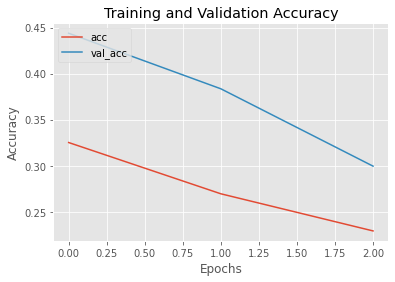

In [ ]:
# plot accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["accuracy"], label="acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

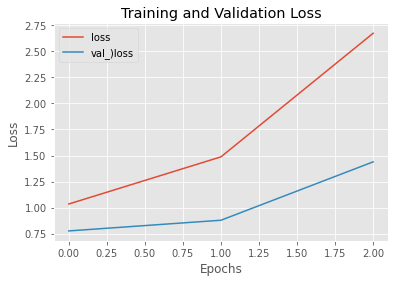

In [ ]:
# plot loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="loss")
plt.plot(H.history["val_loss"], label="val_)loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")

In [ ]:
print(H.history["accuracy"])
print(H.history["val_accuracy"])
print(H.history["loss"])
print(H.history["val_loss"])

[0.325155109167099, 0.269458532333374, 0.22913141548633575]
[0.44388043880462646, 0.38353073596954346, 0.29949238896369934]
[1.034645915031433, 1.487118124961853, 2.673398733139038]
[0.7762791514396667, 0.8787727355957031, 1.4391096830368042]


In [ ]:
# save model
rnn_model.save("models/action_classifier")

KeyboardInterrupt: ignored

## Vision Transformer
---

In [ ]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class Attention(nn.Module):
    """
    Attention mechanism

    paramteres:
    -----------
    dim: int
        The input and output dimension per token features.

    n_heads : int
        Number of attention heads

    qkv_bias : bool
        Dropout probability applied to the query, key and value tensor

    proj_p : float
        Dropout probability applied to the output tensor.

    Attributes
    ----------
    scale: float
        Normalizing constant for the dot product.

    qkv: nn.Linear
        Linear projection for the query, key and value

    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention heads
        and maps it into a new space.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads  #Define dimensionality of each head.
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim*3, bias =qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """
        :param x:
            shape (n_samples, n_patches + 1, dim) +1 is for class token as 1st token in the sequence
        :return: Torch.Tensor
            shape(n_samples, n_patches + 1, dim)
        """
        n_samples, n_tokens, dim = x.shape
        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # n_samples, n_patches + 1, * 3 * dim
        qkv = qkv.reshape(
            n_samples, n_tokens, 3, self.n_heads, self.head_dim
        ) # n_samples, n_patches  + 1,  3 , n_heads, head_dim
        qkv = qkv.permute(
            2, 0, 3, 1, 4
        ) # (3, n_samples, n_heads, n_patches + 1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)
        dot_p = (
            q @ k_t
        ) * self.scale
        attn = dot_p.softmax(dim=1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose( 1, 2) #(n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2) # n_samples, n_patches + 1, dim

        x = self.proj(weighted_avg)
        x = self.proj_drop(x)

        return x

class MLP(nn.Module):
    """
    Multilayer perceptron

    :parameters
    -----------
    in_features : int
        Number of input features.

    hidden_features : int
        Number of nodes in the hidden layer

    out_features : int
        Number of output features.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """
        Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.

        :Returns
        ---------
        torch.Tensor
            Shape (n_samples, n_patches + 1, out_features)
        """
        x = self.fc1(
            x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)

        return x

class Block(nn.Module):
    """
    Transformer block

    :parameter:
    dim : int
        Embedding dimension

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension size of the MLP module with respect to dim.

    qkv_bias : bool
        if True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability


    Attributes
    ----------
    norm1, norm2 : LayerNorm
        LayerNormalization
    attn : Attention
        attention module.

    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0, attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
            dim,
            n_heads=n_heads,
            qkv_bias=qkv_bias,
            attn_p = attn_p,
            proj_p = p,
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=hidden_features,
            out_features=dim,
        )
    def forward(self, x):
        """
        Run forward pass
        :param x: torch.Tensor, Shape - (n_samples, n_patches + 1, dim)
        :return:
        torch.Tensor, Shape - (n_samples, n_patches + 1, dim)
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x

class visionTransformer(nn.Module):
    """
    Simplified implementation of the vision transformer

    :parameter
    img_size : int
        Both height and the width of the image (it is a square).

    patch_size : int
        Both height and the width of the patch (it is a square).

    in_chans : int
        Number of input channels.

    n_classes : int
        Number of classes.

    embed_dim : int
        Dimensionality of the token embeddings
    depth : int
        Number of blocks.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension of the MLP module
    qkv_bias : bool
        if True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability

    Attributes:
    patch_embed : PatchEmbed
        Instance of PatchEmbed Layer.
    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has embed_dim elements.

    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has (n_patches + 1) * embed_dim elements.

    pos_drop : nn.Dropout
        Dropout layer.

    blocks : nn.ModuleList
        List of Block modules.

    norm : nn.LayerNorm
        Layer Normalization
    """
    def __init__(self,
                 n_classes=18,
                 embed_dim=512,
                 n_frames=20,
                 depth=4,
                 n_heads=4,
                 mlp_ratio=2.,
                 qkv_bias=True,
                 p=0.,
                 attn_p=0.,
                 ):
        super(visionTransformer, self).__init__()
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, 1+ n_frames, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim = embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        """
        Run the forward pass.
        :param self: x : torch.Tensor
        Shape (n_samples, num_frames, features_size

        :return:
        logits : torch.Tensor
            Logits over all the classes - (n_samples, n_classes)
        """
        n_samples = x.shape[0]
        #x = self.patch_embed(x)

        cls_token = self.cls_token.expand(
            n_samples, -1, -1
        ) # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)

        x = x + self.pos_embed # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)

        cls_token_final = x[:, 0] # just CLS token
        #x = torch.nn.functional.softmax(self.head(cls_token_final), dim=1)
        x = self.head(cls_token_final)

        return x

In [ ]:
vt_model = visionTransformer(n_classes=17, )

## Save dataset
---

In [ ]:
features, labels = [], []
i = 1

for idx in range(0, len(trainList), 50):
    features, labels = [], []

    for fp in range(idx, idx+50):
        # print(f"[INFO] storing games {idx+1}-{idx+51}")    

        filepath = "labels/" + trainList[fp] + "/"
        print(f"[INFO] {fp+1}/500 games processed")

        [features_1, features_2, labels_1, labels_2] = getGameData(filepath, 
                                                        num_classes=17, 
                                                        event_mapping=GV.EVENT_DICTIONARY_V2)
        if features_1 is None:
            continue

        features_1, _ = divideGame(features_1, labels_1)
        features_2, _ = divideGame(features_2, labels_2)

        pred_1 = model.predict_on_batch(features_1)
        pred_2 = model.predict_on_batch(features_2)

        windows_1 = getWindows(pred_1)
        windows_2 = getWindows(pred_2)

        features_1, labels_1 = divideGame(features_1, labels_1, binary=False)
        features_2, labels_2 = divideGame(features_2, labels_2, binary=False)

        [features_1, labels_1] = segmentActions(windows_1, features_1, labels_1)
        [features_2, labels_2] = segmentActions(windows_2, features_2, labels_2)

        if features_1 is None or len(features_1.shape) != 3 or \
            features_2 is None or len(features_2.shape) != 3:
            continue

        if len(features) != 0:
            features = np.concatenate((features, features_1, features_2), axis=0)
            labels = np.concatenate((labels, labels_1, labels_2), axis=0)
        else:
            features = np.concatenate((features_1, features_2), axis=0)
            labels = np.concatenate((labels_1, labels_2), axis=0)

    with open("dataset/train_" + str(i) +"_features.npy", "wb") as f:
        np.save(f, features)

    with open("dataset/train_" + str(i) + "_labels.npy", "wb") as f:
        np.save(f, labels)
    
    i += 1

In [7]:
def getPrePostFrames(peak, features):
    pre, post = [], []
    start = peak - 10
    end = peak - 1
    try:
        arr = [np.array(features[f]) for f in range(start, end+1)]
        pre.extend(arr)
    except:
        arr = [np.array(features[f]) for f in range(0, 11)]
        pre.extend(arr)
    
    start = peak + 1
    end = peak + 10
    try:
        arr = [np.array(features[f]) for f in range(start, end+1)]
        post.extend(arr)
    except:
        arr = [np.array(features[f]) for f in range(len(features)-10, len(features))]
        post.extend(arr)

    return (pre, post)

In [8]:
pre_5_features, post_5_features, lab_5 = [], [], []
pre_6_features, post_6_features, lab_6 = [], [], []

i=1

for game in trainList:
    filepath = "labels/" + game + "/"
    print(f"[INFO] {i}/400 games processed")
    i+=1

    [features_1, features_2, labels_1, labels_2] = getGameData(filepath, 
                                                    num_classes=17, 
                                                    event_mapping=GV.EVENT_DICTIONARY_V2)
    if features_1 is None or features_2 is None:
        continue
    
    for (f_, l_) in zip([features_1, features_2], [labels_1, labels_2]):
        for (idx, l) in enumerate(l_):
            if l[10] or l[11] or l[12]:
                pre, post = getPrePostFrames(idx, f_)
                pre_6_features.append(pre)
                post_6_features.append(post)
                lab_6.append([l[10], l[11], l[12]])


[INFO] 1/400 games processed
[INFO] 2/400 games processed
[INFO] 3/400 games processed
[INFO] 4/400 games processed
[INFO] 5/400 games processed
[INFO] 6/400 games processed
[INFO] 7/400 games processed
[INFO] 8/400 games processed
[INFO] 9/400 games processed
[INFO] 10/400 games processed
[INFO] 11/400 games processed
[INFO] 12/400 games processed
[INFO] 13/400 games processed
[INFO] 14/400 games processed
[INFO] 15/400 games processed
[INFO] 16/400 games processed
[INFO] 17/400 games processed
[INFO] 18/400 games processed
[INFO] 19/400 games processed
[INFO] 20/400 games processed
[INFO] 21/400 games processed
[INFO] 22/400 games processed
[INFO] 23/400 games processed
[INFO] 24/400 games processed
[INFO] 25/400 games processed
[INFO] 26/400 games processed
[INFO] 27/400 games processed
[INFO] 28/400 games processed
[INFO] 29/400 games processed
[INFO] 30/400 games processed
[INFO] 31/400 games processed
[INFO] 32/400 games processed
[INFO] 33/400 games processed
[INFO] 34/400 games

In [9]:
print(np.array(pre_6_features).shape, np.array(post_6_features).shape, np.array(lab_6).shape)

(19286, 10, 8576) (19286, 10, 8576) (19286, 3)


In [10]:
with open("dataset/pre_6_features.npy", "wb") as f:
    np.save(f, pre_6_features)

In [11]:
with open("dataset/post_6_features.npy", "wb") as f:
    np.save(f, post_6_features)

In [12]:
with open("dataset/lab_6.npy", "wb") as f:
    np.save(f, lab_6)

## Subclass Training
---

In [4]:
# import
from tensorflow.keras.layers import (
	Dense,
    Flatten,
    Dropout,
    LSTM,
    GRU,
    Bidirectional
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input

class ActionClassifier:

    @staticmethod
    def build(timesteps=15, dim=8576, classes=17):
        model = Sequential()
        model.add(Bidirectional(GRU(64, return_sequences=True),
                                input_shape=(timesteps, dim),
                                merge_mode='sum'))
        # model.add(Dropout(0.3))
        model.add(Bidirectional(GRU(64), merge_mode='sum'))
        # model.add(Dropout(0.2))
        model.add(Flatten())

        # model.add(Dense(64, activation="relu"))
        # model.add(Dense(64, activation="relu"))
        # model.add(Dropout(0.3))

        # Add a Dense layer.
        model.add(Dense(classes, activation="softmax"))

        return model

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

opt = Adam(learning_rate=1e-3)
loss = CategoricalCrossentropy()
rnn_model = ActionClassifier.build(timesteps=5, classes=3)
rnn_model.compile(loss=loss, optimizer=opt,
    metrics=METRICS)

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 64)            3318528   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               49920     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 3,368,643
Trainable params: 3,368,643
Non-trainable params: 0
_________________________________________________________________


In [5]:
def getClassWeights(labels):
    n_samples = len(labels)
    n_classes = len(labels[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in labels:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights))
    return dict(zip(class_labels, class_weights))

In [6]:
# load features and labels
# pre_features = np.load("dataset/pre_5_features.npy")
post_features = np.load("dataset/post_5_features.npy")
labels = np.load("dataset/lab_5.npy")

In [7]:
pre_features.shape

(19286, 10, 8576)

In [7]:
pre_features = pre_features[:, 5:, :]
pre_features.shape

(46696, 5, 8576)

In [7]:
post_features = post_features[:, :5, :]
post_features.shape

(46696, 5, 8576)

In [12]:
# post_features = post_features[35022:]
# labels = labels[35022:]

In [8]:
partition = int(len(post_features) * 0.8)
print(partition)

37356


In [ ]:
# rnn_model = tensorflow.keras.models.load_model("models/post_5_classifier")

In [9]:
# train_df = tensorflow.data.Dataset.from_tensor_slices((pre_features[:partition], labels[:partition]))
# train_df = train_df.cache().shuffle(200).batch(16).prefetch(tensorflow.data.experimental.AUTOTUNE)

# val_df = tensorflow.data.Dataset.from_tensor_slices((pre_features[partition:], labels[partition:]))
# val_df = val_df.cache().shuffle(200).batch(16).prefetch(tensorflow.data.experimental.AUTOTUNE)

train_df = tensorflow.data.Dataset.from_tensor_slices((post_features[:partition], labels[:partition]))
train_df = train_df.cache().shuffle(200).batch(32).prefetch(tensorflow.data.experimental.AUTOTUNE)

val_df = tensorflow.data.Dataset.from_tensor_slices((post_features[partition:], labels[partition:]))
val_df = val_df.cache().shuffle(200).batch(32).prefetch(tensorflow.data.experimental.AUTOTUNE)

In [10]:
acc, loss, val_acc, val_loss = [], [], [], []

In [17]:
H = rnn_model.fit(train_df,
                  epochs=1,
                  validation_data=val_df,
                  class_weight = getClassWeights(labels))

1168/1168 [==============================] - 176s 151ms/step - loss: 0.0901 - tp: 36268.0000 - fp: 984.0000 - tn: 73713.0000 - fn: 1103.0000 - accuracy: 0.9814 - precision: 0.9736 - recall: 0.9705 - auc: 0.9967 - prc: 0.9939 - val_loss: 0.1688 - val_tp: 8823.0000 - val_fp: 464.0000 - val_tn: 18214.0000 - val_fn: 519.0000 - val_accuracy: 0.9649 - val_precision: 0.9500 - val_recall: 0.9444 - val_auc: 0.9906 - val_prc: 0.9828


In [16]:
acc.extend(H.history["accuracy"])
val_acc.extend(H.history["val_accuracy"])
loss.extend(H.history["loss"])
val_loss.extend(H.history["val_loss"])

In [16]:
rnn_model.save("models/post_5_classifier")

INFO:tensorflow:Assets written to: models/post_5_classifier/assets


INFO:tensorflow:Assets written to: models/post_5_classifier/assets


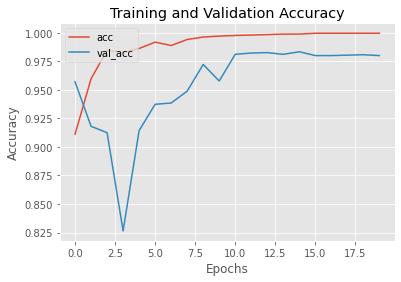

In [17]:
# plot accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(acc, label="acc")
plt.plot(val_acc, label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

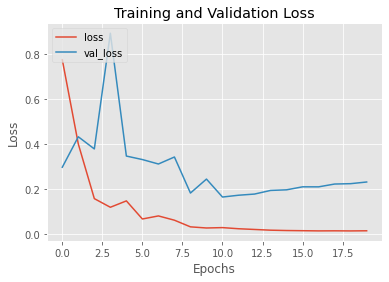

In [18]:
# plot accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")

## Final Testing
---

In [4]:
from SoccerNet.Downloader import getListGames

trainList = []
trainList.extend(getListGames(['train']))
trainList.extend(getListGames(['valid']))
testList = getListGames(['test'])
challengeList = getListGames(['challenge'])

print(f"Games in trainList: {len(trainList)}")
print(f"Games in testList: {len(testList)}")
print(f"Games in challengeList: {len(challengeList)}")

Games in trainList: 400
Games in testList: 100
Games in challengeList: 50


In [19]:
# load models
model = tensorflow.keras.models.load_model("models/naive_classifier")
rnn_model_grouped = tensorflow.keras.models.load_model("models/action_classifier_7_11window")
rnn_model = tensorflow.keras.models.load_model("models/action_classifier_17_11window")
pre_2_model = tensorflow.keras.models.load_model("models/pre_2_classifier")
# post_2_model = tensorflow.keras.models.load_model("models/post_2_classifier")
# pre_4_model = tensorflow.keras.models.load_model("models/pre_4_classifier")
post_4_model = tensorflow.keras.models.load_model("models/post_4_classifier")
pre_5_model = tensorflow.keras.models.load_model("models/pre_5_classifier")
# post_5_model = tensorflow.keras.models.load_model("models/post_5_classifier")
pre_6_model = tensorflow.keras.models.load_model("models/pre_6_classifier")
# post_6_model = tensorflow.keras.models.load_model("models/post_6_classifier")

In [6]:
context = np.array([0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1., 
                    0.95, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5], dtype="float")
context = np.expand_dims(context, axis=1)

timestep = 1

def contextLabel(labels):
    # labels = labels * context
    label = np.sum(labels, axis=0)
    return label

def binaryLabel(labels):
    label = np.sum(labels, axis=0)
    if np.sum(labels) == 0:
        return 0
    else:
        return 1

def divideGame(features, labels, binary=True, stride=1):
    feat_ = []
    lab_ = []

    for i in range(0, len(features), stride):
        if i+timestep > len(features):
            break
        feat_.append(features[i : i+timestep])
        if binary:
            lab_.append(binaryLabel(labels[i : i+timestep]))
        else:
            lab_.append(contextLabel(labels[i : i+timestep]))

    feat_ = np.asanyarray(feat_)
    lab_ = np.asanyarray(lab_)
    feat_ = np.reshape(feat_, (feat_.shape[0], feat_.shape[-1]))
    return (feat_, lab_)


In [7]:
# get windows from predictions
def getWindows(pred, threshold=0.2):
    windows = []
    pred = pred > threshold
    idx = 0

    while idx < len(pred):
        if pred[idx]:
            start = idx
            while idx < len(pred) and pred[idx]:
                idx += 1
            if idx-1 - start >= 15:
                windows.extend([[start, start+5], [start+5, start+10], [start+10, idx-1]])
            elif idx-1 - start >= 10:
                windows.extend([[start, start+5], [start+5, idx-1]])
            else:
                windows.append([start, idx-1])
        idx += 1
    
    return np.asarray(windows)

In [8]:
# segment actions from game for event classification
def segmentActions(windows, features, labels, max_window=15):
    feat_ = []
    lab_ = []

    for (start, end) in windows:
        temp_feat = []
        temp_feat.extend([np.array(features[f]) for f in range(start, end+1)])
        if end+1 - start < max_window: 
            temp_feat.extend(np.array([0] * features.shape[-1]) for _ in range(max_window - (end+1 - start)))
        elif end+1 - start < max_window:
            temp_feat = temp_feat[:max_window]

        temp_feat = np.asarray(temp_feat)
        feat_.append(np.array(temp_feat))

        temp_lab = contextLabel(labels[start : end+1])
        if np.sum(temp_lab) > 1:
            temp_lab = temp_lab / np.sum(temp_lab)
        lab_.append(temp_lab)

    feat_ = np.array(feat_)
    lab_ = np.array(lab_)
    return (feat_, lab_)

In [9]:
def getPrePostFrames(peak, features):
    pre, post = [], []
    start = peak - 5
    end = peak - 1
    try:
        arr = [np.array(features[f]) for f in range(start, end+1)]
        pre.extend(arr)
    except:
        arr = [np.array(features[f]) for f in range(0, 6)]
        pre.extend(arr)
    
    start = peak + 1
    end = peak + 5
    try:
        arr = [np.array(features[f]) for f in range(start, end+1)]
        post.extend(arr)
    except:
        arr = [np.array(features[f]) for f in range(len(features)-5, len(features))]
        post.extend(arr)

    return (pre, post)

In [15]:
label2event_2 = {
    0: "Goal",
    1: "Shots on target",
    2: "Shots off target",
    3: "Corner",
}

label2event_4 = {
    0: "Yellow card",
    1: "Red card",
    2: "Yellow->red card",
    3: "Offside",
}

label2event_5 = {
    0: "Clearance",
    1: "Ball out of play",
    2: "Throw-in",
}

label2event_6 = {
    0: "Foul",
    1: "Indirect free-kick",
    2: "Direct free-kick",
}

In [16]:
def getSubclass(peak, features, label):
    pre, post = getPrePostFrames(peak, features)
    pre = np.expand_dims(pre, axis=0)
    post = np.expand_dims(post, axis=0)
    if label == 2:
        pre_pred = pre_2_model.predict((pre))
        # post_pred = post_2_model.predict(post)
        # if np.max(pre_pred) > np.max(post_pred):
        return label2event_2[np.argmax(pre_pred)], pre_pred
        # return label2event_2[np.argmax(post_pred)], post_pred
    elif label == 4:
        # pre_pred = pre_4_model.predict(pre)
        post_pred = post_4_model.predict(post)
        # if np.max(pre_pred) > np.max(post_pred):
        #     return label2event_4[np.argmax(pre_pred)], pre_pred
        return label2event_4[np.argmax(post_pred)], post_pred
    elif label == 5:
        pre_pred = pre_5_model.predict(pre)
        # post_pred = post_5_model.predict(post)
        # if np.max(pre_pred) > np.max(post_pred):
        return label2event_5[np.argmax(pre_pred)], pre_pred
        # return label2event_5[np.argmax(post_pred)], post_pred
    else:
        pre_pred = pre_6_model.predict(pre)
        # post_pred = post_6_model.predict(post)
        # if np.max(pre_pred) > np.max(post_pred):
        return label2event_6[np.argmax(pre_pred)], pre_pred
        # return label2event_6[np.argmax(post_pred)], post_pred

In [13]:
import json
import os

res_path = "results"

def sec2time(sec):
    min = sec // 60
    sec -= (min*60)
    if sec < 10:
        return str(min) + ":0" + str(sec)
    return str(min) + ":" + str(sec)

# save predictions
def savePreds(preds, windows, features, filepath):
    # labels = []
    predictions = {"annotations": []}
    half = 0
    for (pred_half, window_half) in zip(preds, windows):
        half += 1
        for (pred, window) in zip(pred_half, window_half):
            event = {}
            # get timestamp
            sec = window[0] + ((window[1] - window[0]) // 2)
            time = sec2time(sec)

            # get class
            idx = np.argmax(pred)
            if idx in [0, 1, 3]:
                action = GV.INVERSE_EVENT_DICTIONARY_V2[idx]
            elif idx == 5:
                if half == 1:
                    action, pred = getSubclass(sec, features[0], 5)
                    # if np.max(pred_) < np.max(pred):
                    #     action = GV.INVERSE_EVENT_DICTIONARY_V2[5]
                    #     pred = pred_
                else:
                    action, pred = getSubclass(sec, features[1], 5)
                    # if np.max(pred_) < np.max(pred):
                    #     action = GV.INVERSE_EVENT_DICTIONARY_V2[5]
                    #     pred = pred_
            elif idx == 2:
                if half == 1:
                    action, pred = getSubclass(sec, features[0], 2)
                    # if np.max(pred_) < np.max(pred):
                    #     action = GV.INVERSE_EVENT_DICTIONARY_V2[2]
                    #     pred = pred_
                else:
                    action, pred = getSubclass(sec, features[1], 2)
                    # if np.max(pred_) < np.max(pred):
                    #     action = GV.INVERSE_EVENT_DICTIONARY_V2[2]
                    #     pred = pred_
            elif idx == 4:
                if half == 1:
                    action, pred = getSubclass(sec, features[0], 4)
                    # if np.max(pred_) < np.max(pred):
                    #     action = GV.INVERSE_EVENT_DICTIONARY_V2[4]
                    #     pred = pred_
                else:
                    action, pred = getSubclass(sec, features[1], 4)
                    # if np.max(pred_) < np.max(pred):
                    #     action = GV.INVERSE_EVENT_DICTIONARY_V2[4]
                    #     pred = pred_
            else:
                if half == 1:
                    action, pred = getSubclass(sec, features[0], 6)
                    # if np.max(pred_) < np.max(pred):
                    #     action = GV.INVERSE_EVENT_DICTIONARY_V2[6]
                    #     pred = pred_
                else:
                    action, pred = getSubclass(sec, features[1], 6)
                    # if np.max(pred_) < np.max(pred):
                    #     action = GV.INVERSE_EVENT_DICTIONARY_V2[6]
                    #     pred = pred_

            # labels.append([action, time])
            predictions["annotations"].append({"gameTime": str(half) + " - " + time,
                                            "label": action,
                                            "position": str(sec * 1000),
                                            "half": str(half),
                                            "confidence": str(np.max(pred))})
    
    res_path = "results/" + filepath[7:]
    if not os.path.exists(res_path):
        os.makedirs(res_path)
    with open(res_path + "results_spotting.json", "w") as f:
        f.write(json.dumps({"UrlLocal": filepath[7:-1],
            "predictions": predictions["annotations"]}, indent=4))

    # return labels


In [14]:
i=1
for game in testList[:1]:
    filepath = "labels/" + game + "/"
    print(f"[INFO] {i}/100 games processed")
    i+=1

    [features_1, features_2, labels_1, labels_2] = getGameData(filepath, 
                                                    num_classes=17, 
                                                    event_mapping=GV.EVENT_DICTIONARY_V2)
    if features_1 is None or features_2 is None:
        continue

    pred_1 = model.predict_on_batch(features_1)
    pred_2 = model.predict_on_batch(features_2)

    windows_1 = getWindows(pred_1)
    windows_2 = getWindows(pred_2)

    [seg_features_1, labels_1] = segmentActions(windows_1, features_1, labels_1, max_window=11)
    [seg_features_2, labels_2] = segmentActions(windows_2, features_2, labels_2, max_window=11)

    pred_1 = rnn_model.predict_on_batch(seg_features_1)
    pred_1 = np.asarray(pred_1)
    pred_2 = rnn_model.predict_on_batch(seg_features_2)
    pred_2 = np.asarray(pred_2)

    savePreds((pred_1, pred_2), (windows_1, windows_2), (features_1, features_2), filepath)

[INFO] 1/100 games processed


NameError: ignored

In [83]:
from SoccerNet.Evaluation.ActionSpotting import evaluate
results = evaluate(SoccerNet_path="labels/", Predictions_path="results/",
                   split="test", version=2, prediction_file="results_spotting.json")

print("tight Average mAP: ", results["a_mAP"])
print("tight Average mAP per class: ", results["a_mAP_per_class"])
print("tight Average mAP visible: ", results["a_mAP_visible"])
print("tight Average mAP visible per class: ", results["a_mAP_per_class_visible"])
print("tight Average mAP unshown: ", results["a_mAP_unshown"])
print("tight Average mAP unshown per class: ", results["a_mAP_per_class_unshown"])

100%|██████████| 12/12 [00:25<00:00,  2.10s/it]

tight Average mAP:  0.10437853644342353
tight Average mAP per class:  [0.01298701298701299, 0.09090909090909093, 0.1008464724615595, 0.09065082644628102, 0.03305785123966942, 0.10405895661143404, 0.08779190062594705, 0.09090909090909093, 0.09090909090909093, 0.09090909090909093, 0.2518373629967314, 0.08405060259852237, 0.16859504132231404, 0.45031293307003895, 0.026609795542325277, 0.0, 0.0]
tight Average mAP visible:  0.11665090261341565
tight Average mAP visible per class:  [0.030303030303030297, 0.1776859504132232, 0.1171120325360046, 0.09063360881542702, 0.040404040404040394, 0.10517644841698114, 0.08866263199742457, 0.09090909090909093, 0.09090909090909093, 0.09090909090909093, 0.256902195586509, 0.1269510597499702, 0.1730769230769231, 0.47014147447309307, 0.033288675928166304, 0.0, 0.0]
tight Average mAP unshown:  0.06953056930690993
tight Average mAP unshown per class:  [0.0, 0.09090909090909093, 0.0, 0.09090909090909093, 0.01298701298701299, 0.11111111111111115, 0.0, 0.0, 0.072

In [ ]:
from SoccerNet.Evaluation.ActionSpotting import evaluate
results = evaluate(SoccerNet_path="labels/", Predictions_path="results/",
                   split="test", version=2, prediction_file="results_spotting.json")

print("tight Average mAP: ", results["a_mAP"])
print("tight Average mAP per class: ", results["a_mAP_per_class"])
print("tight Average mAP visible: ", results["a_mAP_visible"])
print("tight Average mAP visible per class: ", results["a_mAP_per_class_visible"])
print("tight Average mAP unshown: ", results["a_mAP_unshown"])
print("tight Average mAP unshown per class: ", results["a_mAP_per_class_unshown"])

## Test Naive Classifier with 11 window size
---

In [17]:
def temp(features, windows):
    feat_ = []

    for (s, e) in windows:
        peak = s + ((e - s) // 2)
        start = peak - 5
        end = peak + 5
        temp_feat = []
        if start < 0:
            arr = [np.array(features[f]) for f in range(0, 11)]
            assert(len(arr) == 11)
        elif end+1 > len(features)-1:
            arr = [np.array(features[f]) for f in range(len(features)-11, len(features))]
            assert(len(arr) == 11)
        else:
            arr = [np.array(features[f]) for f in range(start, end+1)]
            assert(len(arr) == 11)
        temp_feat.extend(arr)
        temp_feat = np.asarray(temp_feat)
        feat_.append(np.array(temp_feat))

    feat_ = np.array(feat_)
    return feat_

In [25]:
import json
import os

def sec2time(sec):
    min = sec // 60
    sec -= (min*60)
    if sec < 10:
        return str(min) + ":0" + str(sec)
    return str(min) + ":" + str(sec)

# save predictions
def savePreds_(preds, preds_grouped , windows, features, filepath):
    # labels = []
    predictions = {"annotations": []}
    half = 0
    for (pred_half, pred_grouped_half, window_half) in zip(preds, preds_grouped, windows):
        half += 1
        for (pred, pred_g, window) in zip(pred_half, pred_grouped_half, window_half):
            event = {}
            # get timestamp
            sec = window[0] + ((window[1] - window[0]) // 2)
            time = sec2time(sec)

            # get class
            # if np.max(pred) < 0.7:
            #     continue
            og_pred = pred
            idx_p = np.argmax(pred)
            idx_pg = np.argmax(pred_g)

            if idx_p in [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]:
                action = GV.INVERSE_EVENT_DICTIONARY_V2[idx_p]
            else:
                # og_pred = pred
                # idx = np.argmax(pred)
                # action = GV.INVERSE_EVENT_DICTIONARY_V2[idx]
                
                if idx_pg in [0, 1, 3]:
                    action = GV.INVERSE_EVENT_DICTIONARY_V2[idx_pg]
                elif idx_pg == 5:
                    if half == 1:
                        action, pred = getSubclass(sec, features[0], 5)
                        # if np.max(pred_) < np.max(pred):
                        #     action = GV.INVERSE_EVENT_DICTIONARY_V2[5]
                        #     pred = pred_
                    else:
                        action, pred = getSubclass(sec, features[1], 5)
                        # if np.max(pred_) < np.max(pred):
                        #     action = GV.INVERSE_EVENT_DICTIONARY_V2[5]
                        #     pred = pred_
                    if action != "Clearance" and np.max(pred) < 0.95:
                        continue
                    elif action == "Clearance" and np.max(pred) < 0.5:
                        continue
                elif idx_pg == 2:
                    # if idx == 5 and np.max(pred) < 0.75:
                    #     # FP shot on target
                    #     continue
                    if half == 1:
                        action, pred = getSubclass(sec, features[0], 2)
                        # if np.max(pred_) < np.max(pred):
                        #     action = GV.INVERSE_EVENT_DICTIONARY_V2[2]
                        #     pred = pred_
                    else:
                        action, pred = getSubclass(sec, features[1], 2)
                        # if np.max(pred_) < np.max(pred):
                        #     action = GV.INVERSE_EVENT_DICTIONARY_V2[2]
                        #     pred = pred_
                    if np.max(pred) < 0.6:
                        continue
                elif idx_pg == 4:
                    # if idx == 4 and np.max(pred) > 0.975:
                    #     # bias for Foul
                    #     action = GV.INVERSE_EVENT_DICTIONARY_V2[idx]
                    if half == 1:
                        action, pred = getSubclass(sec, features[0], 4)
                        # if np.max(pred_) < np.max(pred):
                        #     action = GV.INVERSE_EVENT_DICTIONARY_V2[4]
                        #     pred = pred_
                    else:
                        action, pred = getSubclass(sec, features[1], 4)
                        # if np.max(pred_) < np.max(pred):
                        #     action = GV.INVERSE_EVENT_DICTIONARY_V2[4]
                        #     pred = pred_
                    if np.max(pred) < 0.6:
                        continue
                    if action == "Yellow Card":
                        action = "Offside"
                    if action == "Red Card":
                        action == "Yellow Card"
                else:
                    if np.max(pred) < 0.92:
                        # FP Indirect free kick
                        continue
                    if half == 1:
                        action, pred = getSubclass(sec, features[0], 6)
                        # if np.max(pred_) < np.max(pred):
                        #     action = GV.INVERSE_EVENT_DICTIONARY_V2[6]
                        #     pred = pred_
                    else:
                        action, pred = getSubclass(sec, features[1], 6)
                        # if np.max(pred_) < np.max(pred):
                        #     action = GV.INVERSE_EVENT_DICTIONARY_V2[6]
                        #     pred = pred_
                    if np.max(pred) < 0.6:
                        continue
            
            # labels.append([action, time])
            predictions["annotations"].append({"gameTime": str(half) + " - " + time,
                                            "label": action,
                                            "position": str(sec * 1000),
                                            "half": str(half),
                                            "confidence": str(np.max(pred)),
                                            "og conf": str(np.max(og_pred)),
                                            "pred": str(pred),
                                            "og pred": str(og_pred)})
    
    res_path = "challenge/" + filepath[7:]
    if not os.path.exists(res_path):
        os.makedirs(res_path)
    with open(res_path + "results_spotting.json", "w") as f:
        f.write(json.dumps({"UrlLocal": filepath[7:-1],
            "predictions": predictions["annotations"]}, indent=4))

    # return labels

In [26]:
i=1
for game in challengeList:
    filepath = "labels/" + game + "/"
    print(f"[INFO] {i}/100 games processed")
    i+=1

    [features_1, features_2, labels_1, labels_2] = getGameData(filepath, 
                                                    num_classes=17, 
                                                    event_mapping=GV.EVENT_DICTIONARY_V2)
    if features_1 is None or features_2 is None:
        continue

    pred_1 = model.predict_on_batch(features_1)
    pred_2 = model.predict_on_batch(features_2)

    windows_1 = getWindows(pred_1, threshold=0.1)
    windows_2 = getWindows(pred_2, threshold=0.1)

    seg_features_1 = temp(features_1, windows_1)
    seg_features_2 = temp(features_2, windows_2)

    # [seg_features_1, labels_1] = segmentActions(windows_1, features_1, labels_1)
    # [seg_features_2, labels_2] = segmentActions(windows_2, features_2, labels_2)

    pred_1 = rnn_model.predict_on_batch(seg_features_1)
    pred_1 = np.asarray(pred_1)
    pred_2 = rnn_model.predict_on_batch(seg_features_2)
    pred_2 = np.asarray(pred_2)

    pred_1_grouped = rnn_model_grouped.predict_on_batch(seg_features_1)
    pred_1_grouped = np.asarray(pred_1_grouped)
    pred_2_grouped = rnn_model_grouped.predict_on_batch(seg_features_2)
    pred_2_grouped = np.asarray(pred_2_grouped)

    savePreds_((pred_1, pred_2), (pred_1_grouped, pred_2_grouped), (windows_1, windows_2), (features_1, features_2), filepath)

[INFO] 1/100 games processed
[INFO] 2/100 games processed
[INFO] 3/100 games processed
[INFO] 4/100 games processed
[INFO] 5/100 games processed
[INFO] 6/100 games processed
[INFO] 7/100 games processed
[INFO] 8/100 games processed
[INFO] 9/100 games processed
[INFO] 10/100 games processed
[INFO] 11/100 games processed
[INFO] 12/100 games processed
[INFO] 13/100 games processed
[INFO] 14/100 games processed
[INFO] 15/100 games processed
[INFO] 16/100 games processed
[INFO] 17/100 games processed
[INFO] 18/100 games processed
[INFO] 19/100 games processed
[INFO] 20/100 games processed
[INFO] 21/100 games processed
[INFO] 22/100 games processed
[INFO] 23/100 games processed
[INFO] 24/100 games processed
[INFO] 25/100 games processed
[INFO] 26/100 games processed
[INFO] 27/100 games processed
[INFO] 28/100 games processed
[INFO] 29/100 games processed
[INFO] 30/100 games processed
[INFO] 31/100 games processed
[INFO] 32/100 games processed
[INFO] 33/100 games processed
[INFO] 34/100 games

In [24]:
from SoccerNet.Evaluation.ActionSpotting import evaluate
results = evaluate(SoccerNet_path="labels/", Predictions_path="result/",
                   split="test", version=2, prediction_file="results_spotting.json")

print("tight Average mAP: ", results["a_mAP"])
print("tight Average mAP per class: ", results["a_mAP_per_class"])
print("tight Average mAP visible: ", results["a_mAP_visible"])
print("tight Average mAP visible per class: ", results["a_mAP_per_class_visible"])
print("tight Average mAP unshown: ", results["a_mAP_unshown"])
print("tight Average mAP unshown per class: ", results["a_mAP_per_class_unshown"])

100%|██████████| 12/12 [00:23<00:00,  2.00s/it]

tight Average mAP:  0.4986230950012525
tight Average mAP per class:  [0.8830578512396694, 0.5504290979011965, 0.5663850141087726, 0.59892584505059, 0.5217551185061945, 0.14598858797165856, 0.3388127743315382, 0.5377863043332807, 0.602567911274702, 0.6709325485120846, 0.658696807730876, 0.45300379424640663, 0.5330416860074091, 0.6962605347703928, 0.576042402948368, 0.09090909090909093, 0.05199724517906335]
tight Average mAP visible:  0.5689534384125788
tight Average mAP visible per class:  [0.9033693579148122, 0.7375233404781896, 0.589481913654946, 0.6814813976812734, 0.5454830533361192, 0.14606650567713098, 0.3397026743761495, 0.7297855766323148, 0.6025454085553494, 0.7542512160440938, 0.6613428783901203, 0.53664928983036, 0.629555281024262, 0.6974150759775944, 0.6671422603006266, 0.27272727272727265, 0.1776859504132232]
tight Average mAP unshown:  0.2890712654889215
tight Average mAP unshown per class:  [0.0, 0.4847022527491621, 0.0, 0.20600407276922397, 0.26926159521853305, 0.0, 0.0,

In [75]:
from SoccerNet.Evaluation.ActionSpotting import evaluate
results = evaluate(SoccerNet_path="labels/", Predictions_path="results/",
                   split="test", version=2, prediction_file="results_spotting.json")

print("tight Average mAP: ", results["a_mAP"])
print("tight Average mAP per class: ", results["a_mAP_per_class"])
print("tight Average mAP visible: ", results["a_mAP_visible"])
print("tight Average mAP visible per class: ", results["a_mAP_per_class_visible"])
print("tight Average mAP unshown: ", results["a_mAP_unshown"])
print("tight Average mAP unshown per class: ", results["a_mAP_per_class_unshown"])

100%|██████████| 12/12 [00:27<00:00,  2.28s/it]

tight Average mAP:  0.44404035907046424
tight Average mAP per class:  [0.09090909090909093, 0.492493578966959, 0.6006598773587231, 0.5170355076107789, 0.47702177850812666, 0.1893388610611032, 0.3383993132957046, 0.41482921816277085, 0.6147988326530657, 0.6884981882123227, 0.6505617353944374, 0.3123306577862556, 0.5905956242961752, 0.7070596455312603, 0.5686996489965732, 0.18181818181818185, 0.11363636363636362]
tight Average mAP visible:  0.5171909702981402
tight Average mAP visible per class:  [0.09090909090909093, 0.7731264756058145, 0.6175942228744747, 0.6075780782218648, 0.49852340514853355, 0.18997387623223114, 0.3391829318542446, 0.678263637119422, 0.6151702553264541, 0.776099886165195, 0.6566557007924367, 0.39941229062462463, 0.6474076598019095, 0.7078212914272335, 0.6490731475103066, 0.27272727272727265, 0.27272727272727265]
tight Average mAP unshown:  0.23614319325508504
tight Average mAP unshown per class:  [0.0, 0.36521382278402137, 0.0, 0.1454000544909636, 0.269778717048637